# Soft-DTW Divergences – experiment setup

In [1]:
import sys
from pathlib import Path

REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'sdtw_div').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

DATA_DIR = REPO_ROOT / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Imports
Core methods + dataset loader.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from aeon.datasets import load_classification
from sdtw_div.numba_ops import (
    barycenter,
    euclidean_mean,
    mean_cost,
    mean_cost_div,
    sharp_sdtw,
    sharp_sdtw_div,
    sdtw,
    sdtw_div,
    sdtw_value_and_grad,
    sdtw_div_value_and_grad,
    sharp_sdtw_value_and_grad,
    sharp_sdtw_div_value_and_grad,
    mean_cost_value_and_grad,
    mean_cost_div_value_and_grad,
    squared_euclidean_distance,
)


## Load a dataset
UCR ItalyPowerDemand, as a quick baseline for experiments.


In [4]:
X_te, y_te, meta_data = load_classification(
    'ItalyPowerDemand',
    split='test',
    return_metadata=True,
    extract_path=str(DATA_DIR)
)
X_tr, y_tr, _ = load_classification(
    'ItalyPowerDemand',
    split='train',
    return_metadata=True,
    extract_path=str(DATA_DIR)
)
X_tr.shape, X_te.shape


((67, 1, 24), (1029, 1, 24))

## Quick sanity plot
(One train and one test series.)


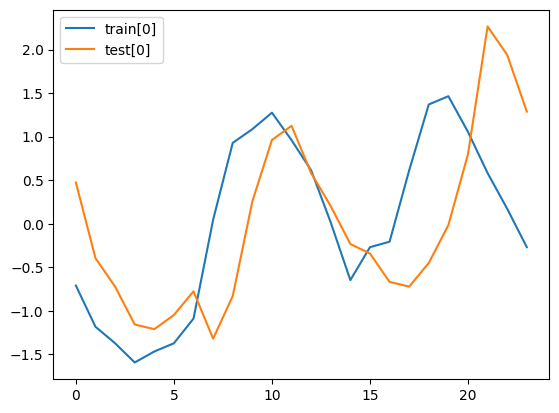

In [5]:
plt.plot(X_tr[0].ravel(), label='train[0]')
plt.plot(X_te[0].ravel(), label='test[0]')
plt.legend()
plt.show()


## Sample a small subset from one class


In [6]:
n = 10
rng = np.random.default_rng(42)
classes = np.unique(y_tr)
k = rng.integers(0, len(classes))
X_a = X_tr[y_tr == classes[k]]
X_aa = X_a[rng.permutation(X_a.shape[0])[:n]]
X_aa = X_aa.swapaxes(1, 2)


## Visualize the subset


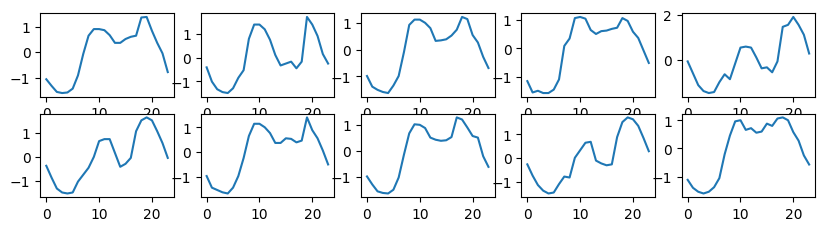

In [7]:
fig = plt.figure(figsize=(10, 5))
for i in range(n):
    ax = fig.add_subplot(4, 5, i + 1)
    ax.plot(X_aa[i].ravel())
plt.show()


## Barycenter vs gamma (soft-DTW)


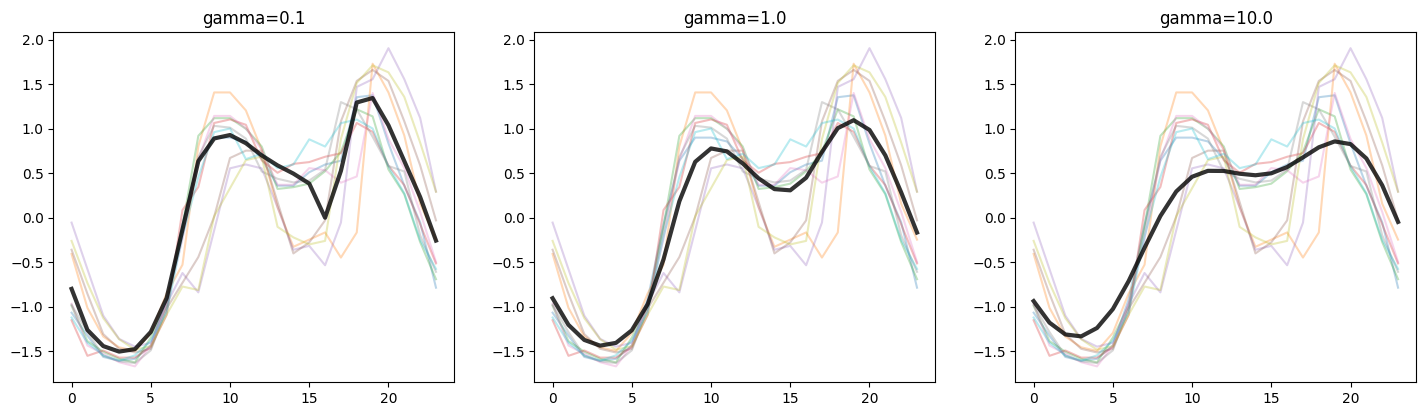

In [8]:
fig = plt.figure(figsize=(30, 10))
for i, gamma in enumerate([0.1, 1.0, 10.0]):
    ax = fig.add_subplot(2, 5, i + 1)
    for x in X_aa:
        ax.plot(x.ravel(), alpha=0.3)
    value_and_grad = lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    Z = barycenter(X_aa, X_init='euclidean_mean', value_and_grad=value_and_grad)
    ax.plot(Z.ravel(), color='k', linewidth=3, alpha=0.8)
    ax.set_title(f'gamma={gamma}')

plt.show()


## Barycenter comparison (Euclidean vs soft-DTW vs divergences)


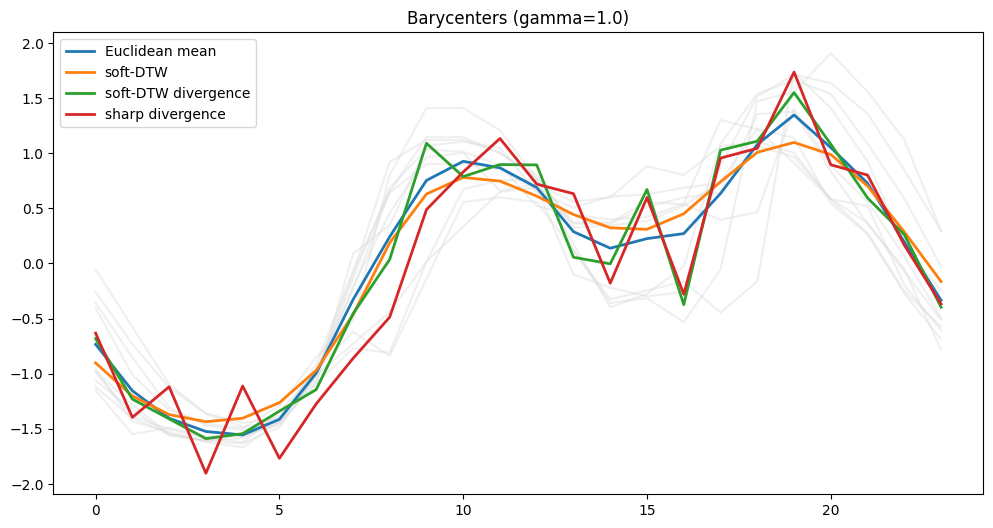

In [9]:
gamma = 1.0

X_euc = euclidean_mean(X_aa)
X_sdtw = barycenter(
    X_aa,
    X_init=X_euc,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
)
X_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
)
X_sharp_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma),
)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for x in X_aa:
    ax.plot(x.ravel(), color='0.85', alpha=0.4)
ax.plot(X_euc.ravel(), label='Euclidean mean', linewidth=2)
ax.plot(X_sdtw.ravel(), label='soft-DTW', linewidth=2)
ax.plot(X_div.ravel(), label='soft-DTW divergence', linewidth=2)
ax.plot(X_sharp_div.ravel(), label='sharp divergence', linewidth=2)
ax.set_title(f'Barycenters (gamma={gamma})')
ax.legend()
plt.show()


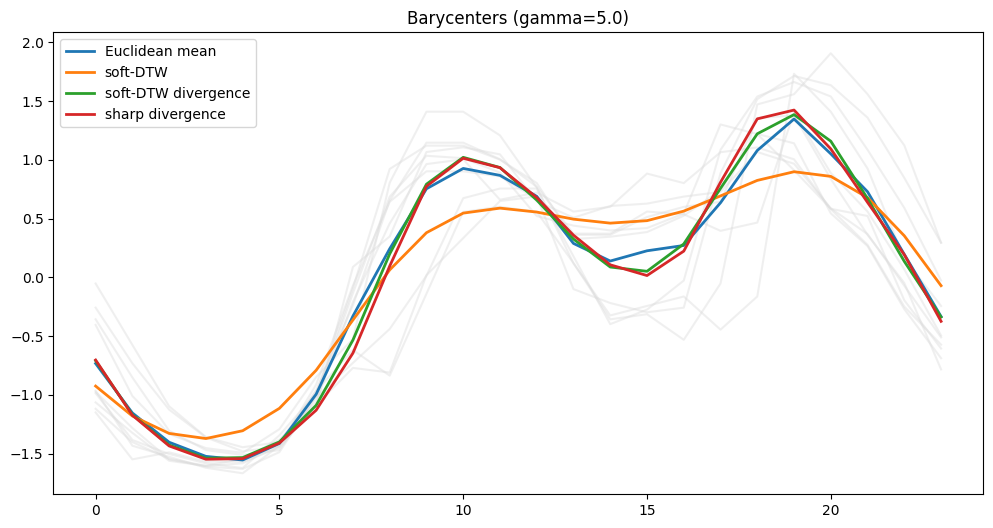

In [10]:
gamma = 5.0

X_euc = euclidean_mean(X_aa)
X_sdtw = barycenter(
    X_aa,
    X_init=X_euc,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
)
X_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
)
X_sharp_div = barycenter(
    X_aa,
    X_init=X_sdtw,
    value_and_grad=lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma),
)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
for x in X_aa:
    ax.plot(x.ravel(), color='0.85', alpha=0.4)
ax.plot(X_euc.ravel(), label='Euclidean mean', linewidth=2)
ax.plot(X_sdtw.ravel(), label='soft-DTW', linewidth=2)
ax.plot(X_div.ravel(), label='soft-DTW divergence', linewidth=2)
ax.plot(X_sharp_div.ravel(), label='sharp divergence', linewidth=2)
ax.set_title(f'Barycenters (gamma={gamma})')
ax.legend()
plt.show()


## Bias demo (soft-DTW vs divergence)
Minimize over X for a fixed Y.


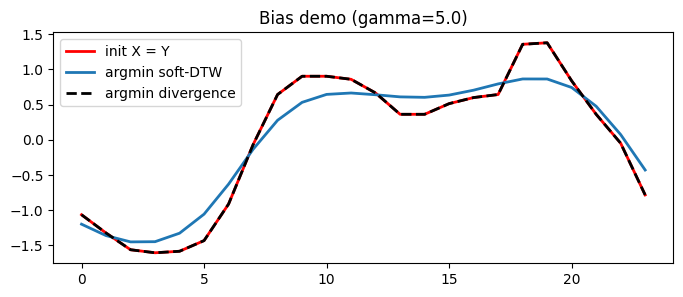

In [11]:
Y = X_aa[0]
X0 = Y.copy()

X_sdtw = barycenter(
    [Y],
    X_init=X0,
    value_and_grad=lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma),
    tol=1e-9,
    max_iter=200,
)
X_div = barycenter(
    [Y],
    X_init=X0,
    value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
    tol=1e-9,
    max_iter=200,
)

plt.figure(figsize=(8, 3))
plt.plot(X0.ravel(), label='init X = Y', color='red', linewidth=2)
plt.plot(X_sdtw.ravel(), label='argmin soft-DTW', linewidth=2)
plt.plot(X_div.ravel(), label='argmin divergence', linestyle='--', color='black', linewidth=2)
plt.title(f'Bias demo (gamma={gamma})')
plt.legend()
plt.show()


## DTW baseline


In [12]:
from sdtw_div.dtw_baseline import dtw_distance

try:
    d = dtw_distance(X_aa[0].ravel(), X_aa[1].ravel(), backend='dtaidistance')
    print('DTW distance (dtaidistance):', d)
except ModuleNotFoundError as e:
    print('DTW backend not installed:', e)


DTW distance (dtaidistance): DtwResult(distance=2.2297407918728798, backend='dtaidistance')


## Prototype classifier (small-scale)
Train one barycenter per class and classify by nearest prototype.


In [13]:

X_tr_T = X_tr.swapaxes(1, 2)
X_te_T = X_te.swapaxes(1, 2)

classes = np.unique(y_tr)[:2]
n_train = 6
n_test = 6
gamma = 1.0

def class_subset(X, y, cls, n):
    idx = np.where(y == cls)[0][:n]
    return [X[i] for i in idx]

protos = {}
for cls in classes:
    Ys = class_subset(X_tr_T, y_tr, cls, n_train)
    protos[cls] = barycenter(
        Ys,
        X_init='euclidean_mean',
        value_and_grad=lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma),
        max_iter=100,
    )

def predict(x, dist_fn):
    best_cls, best_dist = None, float('inf')
    for cls, proto in protos.items():
        d = dist_fn(x, proto)
        if d < best_dist:
            best_dist, best_cls = d, cls
    return best_cls

X_test = []
y_test = []
for cls in classes:
    Xc = class_subset(X_te_T, y_te, cls, n_test)
    X_test.extend(Xc)
    y_test.extend([cls] * len(Xc))

pred_sdtw = [predict(x, lambda a, b: sdtw(a, b, gamma=gamma)) for x in X_test]
pred_div = [predict(x, lambda a, b: sdtw_div(a, b, gamma=gamma)) for x in X_test]

acc_sdtw = np.mean([p == y for p, y in zip(pred_sdtw, y_test)])
acc_div = np.mean([p == y for p, y in zip(pred_div, y_test)])
print(f'Prototype accuracy (soft-DTW): {acc_sdtw:.3f}')
print(f'Prototype accuracy (divergence): {acc_div:.3f}')


Prototype accuracy (soft-DTW): 0.917
Prototype accuracy (divergence): 0.917


## Method registry
List all methods so we can pick a subset in the next cell.


In [14]:
METHODS = {
    'euclidean': {'type': 'mean'},
    'sdtw': {'type': 'barycenter', 'value_and_grad': 'sdtw_value_and_grad'},
    'sdtw_div': {'type': 'barycenter', 'value_and_grad': 'sdtw_div_value_and_grad'},
    'sharp_sdtw': {'type': 'barycenter', 'value_and_grad': 'sharp_sdtw_value_and_grad'},
    'sharp_sdtw_div': {'type': 'barycenter', 'value_and_grad': 'sharp_sdtw_div_value_and_grad'},
    'mean_cost': {'type': 'barycenter', 'value_and_grad': 'mean_cost_value_and_grad'},
    'mean_cost_div': {'type': 'barycenter', 'value_and_grad': 'mean_cost_div_value_and_grad'},
    'dtw_approx': {'type': 'barycenter', 'value_and_grad': 'sdtw_value_and_grad', 'gamma': 0.1},
}
list(METHODS.keys())


['euclidean',
 'sdtw',
 'sdtw_div',
 'sharp_sdtw',
 'sharp_sdtw_div',
 'mean_cost',
 'mean_cost_div',
 'dtw_approx']

## Choose methods to run


In [15]:
SELECTED_METHODS = [
    'euclidean',
    'sdtw',
    'sdtw_div',
    'sharp_sdtw',
    'sharp_sdtw_div',
    'mean_cost',
    'mean_cost_div',
    'dtw_approx',
]
SELECTED_METHODS


['euclidean',
 'sdtw',
 'sdtw_div',
 'sharp_sdtw',
 'sharp_sdtw_div',
 'mean_cost',
 'mean_cost_div',
 'dtw_approx']

## List available datasets (UCR/UEA via aeon)


In [16]:
try:
    from aeon.datasets import get_dataset_meta_data
    meta = get_dataset_meta_data()
    datasets = sorted(meta['Dataset'].tolist())
    print('Number of datasets:', len(datasets))
    print(datasets[:20])
except Exception as e:
    print('Could not list datasets via aeon:', e)


Number of datasets: 190
['ACSF1', 'AbnormalHeartbeat', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'ArticularyWordRecognition', 'AsphaltObstacles', 'AsphaltObstaclesCoordinates', 'AsphaltPavementType', 'AsphaltPavementTypeCoordinates', 'AsphaltRegularity', 'AsphaltRegularityCoordinates', 'AtrialFibrillation', 'BME', 'BasicMotions', 'Beef', 'BeetleFly', 'BinaryHeartbeat']


## Batch evaluation across datasets
Compute prototype-classifier accuracy for each method and dataset.


In [ ]:
MAX_DATASETS = None  # set an int to limit for quick runs
MAX_TRAIN_PER_CLASS = None  # set e.g. 20 for faster runs
MAX_TEST_PER_CLASS = None
GAMMA = 1.0

def _fix_shape(X):
    # aeon often returns (n, 1, T); convert to (n, T, 1)
    if X.ndim == 3 and X.shape[1] == 1:
        return X.swapaxes(1, 2)
    return X

def _subset_class(X, y, cls, n, seed=0):
    idx = np.where(y == cls)[0]
    if n is None or len(idx) <= n:
        return [X[i] for i in idx]
    rng = np.random.default_rng(seed)
    idx = rng.permutation(idx)[:n]
    return [X[i] for i in idx]

def _method_value_and_grad(method, gamma):
    if method == 'sdtw':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sdtw_div':
        return lambda X, Y: sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw':
        return lambda X, Y: sharp_sdtw_value_and_grad(X, Y, gamma=gamma)
    if method == 'sharp_sdtw_div':
        return lambda X, Y: sharp_sdtw_div_value_and_grad(X, Y, gamma=gamma)
    if method == 'mean_cost':
        return mean_cost_value_and_grad
    if method == 'mean_cost_div':
        return mean_cost_div_value_and_grad
    if method == 'dtw_approx':
        return lambda X, Y: sdtw_value_and_grad(X, Y, gamma=0.1)
    return None

def _method_distance(method, x, y, gamma):
    if method == 'euclidean':
        return squared_euclidean_distance(x, y)
    if method == 'sdtw':
        return sdtw(x, y, gamma=gamma)
    if method == 'sdtw_div':
        return sdtw_div(x, y, gamma=gamma)
    if method == 'sharp_sdtw':
        return sharp_sdtw(x, y, gamma=gamma)
    if method == 'sharp_sdtw_div':
        return sharp_sdtw_div(x, y, gamma=gamma)
    if method == 'mean_cost':
        return mean_cost(x, y)
    if method == 'mean_cost_div':
        return mean_cost_div(x, y)
    if method == 'dtw_approx':
        return sdtw(x, y, gamma=0.1)
    raise ValueError(f'Unknown method: {method}')

def compute_prototypes(method, X_train, y_train, gamma):
    protos = {}
    for cls in np.unique(y_train):
        Ys = _subset_class(X_train, y_train, cls, MAX_TRAIN_PER_CLASS, seed=0)
        if method == 'euclidean':
            protos[cls] = euclidean_mean(Ys)
        else:
            valgrad = _method_value_and_grad(method, gamma)
            protos[cls] = barycenter(
                Ys,
                X_init='euclidean_mean',
                value_and_grad=valgrad,
                max_iter=100,
            )
    return protos

def classify_with_prototypes(method, protos, X_test, y_test, gamma):
    preds = []
    for x in X_test:
        best_cls, best_dist = None, float('inf')
        for cls, proto in protos.items():
            d = _method_distance(method, x, proto, gamma)
            if d < best_dist:
                best_dist, best_cls = d, cls
        preds.append(best_cls)
    acc = np.mean([p == y for p, y in zip(preds, y_test)])
    return float(acc)

def filter_datasets(meta_df):
    df = meta_df.copy()
    if 'Channels' in df.columns:
        df = df[df['Channels'] == 1]
    return df

results = []

try:
    meta = get_dataset_meta_data()
    meta = filter_datasets(meta)
    dataset_list = meta['Dataset'].tolist()
except Exception as e:
    print('Could not load metadata for filtering:', e)
    dataset_list = datasets

if MAX_DATASETS is not None:
    dataset_list = dataset_list[:MAX_DATASETS]

for dataset_name in dataset_list:
    try:
        X_te, y_te, _ = load_classification(
            dataset_name,
            split='test',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr, y_tr, _ = load_classification(
            dataset_name,
            split='train',
            return_metadata=True,
            extract_path=str(DATA_DIR),
        )
        X_tr = _fix_shape(X_tr)
        X_te = _fix_shape(X_te)

        if MAX_TEST_PER_CLASS is not None:
            X_test = []
            y_test = []
            for cls in np.unique(y_te):
                Xc = _subset_class(X_te, y_te, cls, MAX_TEST_PER_CLASS, seed=1)
                X_test.extend(Xc)
                y_test.extend([cls] * len(Xc))
        else:
            X_test = [x for x in X_te]
            y_test = list(y_te)

        for method in tqdm(SELECTED_METHODS, desc=dataset_name):
            protos = compute_prototypes(method, X_tr, y_tr, GAMMA)
            acc = classify_with_prototypes(method, protos, X_test, y_test, GAMMA)
            results.append({
                'dataset': dataset_name,
                'method': method,
                'accuracy': acc,
                'train_size': len(X_tr),
                'test_size': len(X_te),
                'n_classes': len(np.unique(y_tr)),
            })
        print('Done:', dataset_name)
    except Exception as e:
        print('Skipping', dataset_name, '->', e)

results_df = pd.DataFrame(results)
results_df.head()


Adiac:  25%|██▌       | 2/8 [00:17<00:51,  8.52s/it]

In [ ]:
RESULTS_PATH = REPO_ROOT / 'results' / 'prototype_results.csv'
RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
results_df.to_csv(RESULTS_PATH, index=False)
RESULTS_PATH
